In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sys
import pickle
from scipy.ndimage import gaussian_filter1d

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print(device, dtype)

from code import *

import warnings
warnings.filterwarnings("ignore")

In [8]:
# parameters
seed = 42
setting = 'disc'
num_hiddens = [16, 64, 256, 1024]
length_scales = [.2, 1, 5, 50]
batch_size = 128
train_batch = 1
test_batch = 10
num_grid = 512
grid_limit = 1.5
lr = 1e-3
num_step = 50000
num_rep = 10
decayRate = .9
n_restarts_optimizer = 100
log_dir = ''

# Data Generation

In [4]:
# make data
data = Data(
    setting=setting, 
    batch_size=batch_size, 
    train_batch=train_batch,
    test_batch=test_batch,
    seed=seed,
    num_grid=num_grid,
    grid_limit=grid_limit,
)

# grid data
x_grid, y_grid = data.x_grid, data.y_grid
ind_id = np.linalg.norm(x_grid, axis=1) <= 1  # in domain
ind_ood = np.logical_not(ind_id)  # out of domain
x_grid_torch = torch.from_numpy(x_grid.astype(np.float32)).to(device)

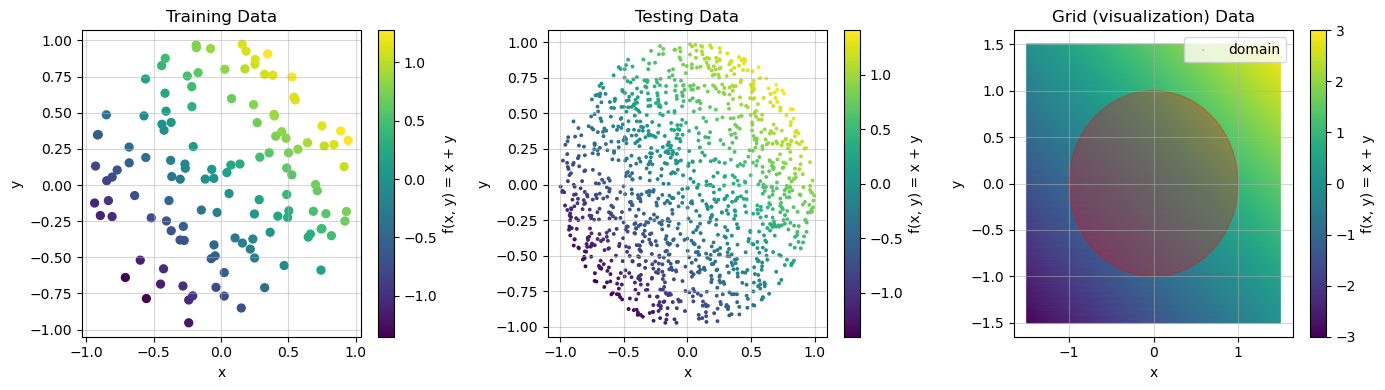

In [6]:
# show data
plt.figure(figsize=(14, 4))
s = 32
for i in range(3):
    plt.subplot(1, 3, 1 + i)
    if i==0:
        x, y = data.get_train()
        plt.title("Training Data")
    elif i==1:
        x, y = [], []
        for j in range(data.test_batch):
            x_, y_ = data.get_test(j)
            x.append(x_.copy())
            y.append(y_.copy())
        x = np.concatenate(x)
        y = np.concatenate(y)
        plt.title("Testing Data")
    else:
        x, y = data.x_grid, data.y_grid
        plt.title("Grid (visualization) Data")

    plt.grid(alpha=.5)
    plt.scatter(*x.T, c=y, s=s * batch_size / x.shape[0])
    plt.colorbar(label='f(x, y) = x + y')
    plt.xlabel('x')
    plt.ylabel('y')

plt.gca().add_patch(plt.Circle((0, 0), 1.0, color='r', fill=True, alpha=.3))
plt.legend(['domain'])

plt.tight_layout()
plt.show()

# Train MLPs

In [ ]:
# train all ReLU models
grid_predictions, mse_trains, mse_tests, mse_ids, mse_oods = [], [], [], [], []

for i, num_hidden in enumerate(num_hiddens):
    model = Calculator(
        num_input=2,
        num_output=1,
        normalized=False,
        num_hidden=num_hidden,
        num_layer=2,
        sigma=1e0,
        nonlinearity=torch.nn.ReLU,
        normalization='std',
        seed=seed
    )
    print(
        'num_hidden:', num_hidden,
        'num parameter:', count_parameters(model),
        'model:', model
    )
    mse_train, mse_test = train(
        model, data, lr=lr, num_step=num_step, decayRate=decayRate
    )
    mse_trains.append(mse_train)
    mse_tests.append(mse_test)
    torch.save(model.state_dict(), log_dir + "add_disc_relu_num_hidden=%s" % num_hidden)

    # compute predictions on grid
    model.eval()
    y_grid_ = model(x_grid_torch).detach().cpu().numpy()[:, 0]
    grid_predictions.append(y_grid_)
    mse_id = np.mean((y_grid[ind_id] - y_grid_[ind_id])**2)
    mse_ood = np.mean((y_grid[ind_ood] - y_grid_[ind_ood])**2)
    mse_ids.append(mse_id)
    mse_oods.append(mse_ood)

    print('MSE_train=%.4e, MSE_test=%.4e, MSE_grid_id=%.4e, MSE_grid_od=%.4e\n' % (
        mse_train, mse_test, mse_id, mse_ood
    ))

results = {
    'grid_predictions': np.array(grid_predictions),
    'mse_trains': np.array(mse_trains),
    'mse_tests': np.array(mse_tests),
    'mse_ids': np.array(mse_ids),
    'mse_oods': np.array(mse_oods),
}
with open(log_dir + 'add_disc_relu_results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Train GPs with different length scales (sklearn)
mse_trains, mse_tests, mse_ids, mse_oods = [], [], [], []
grid_predictions, grid_stds = [], []

for length_scale in length_scales:
  model, output = train_gp(
    data,
    verbose=False,
    lengthscale=length_scale,
    framework='sklearn',
    seed=seed,
    grid_batch_size=10000,
  )

  mse_trains.append(output['mse_train'])
  mse_tests.append(output['mse_test'])
  grid_predictions.append(output['y_grid_'])
  grid_stds.append(output['std_grid'])
  mse_id = np.mean((y_grid[ind_id] - output['y_grid_'][ind_id])**2)
  mse_ood = np.mean((y_grid[ind_ood] - output['y_grid_'][ind_ood])**2)
  mse_ids.append(mse_id)
  mse_oods.append(mse_ood)

  print('length_scale=%s, MSE_train=%.4e, MSE_test=%.4e, MSE_grid_id=%.4e, '
        'MSE_grid_od=%.4e\n' % (length_scale, output['mse_train'],
                                output['mse_test'], mse_id, mse_ood
  ))

results = {
    'grid_predictions': np.array(grid_predictions),
    'grid_stds': np.array(grid_stds),
    'mse_trains': np.array(mse_trains),
    'mse_tests': np.array(mse_tests),
    'mse_ids': np.array(mse_ids),
    'mse_oods': np.array(mse_oods),
}
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

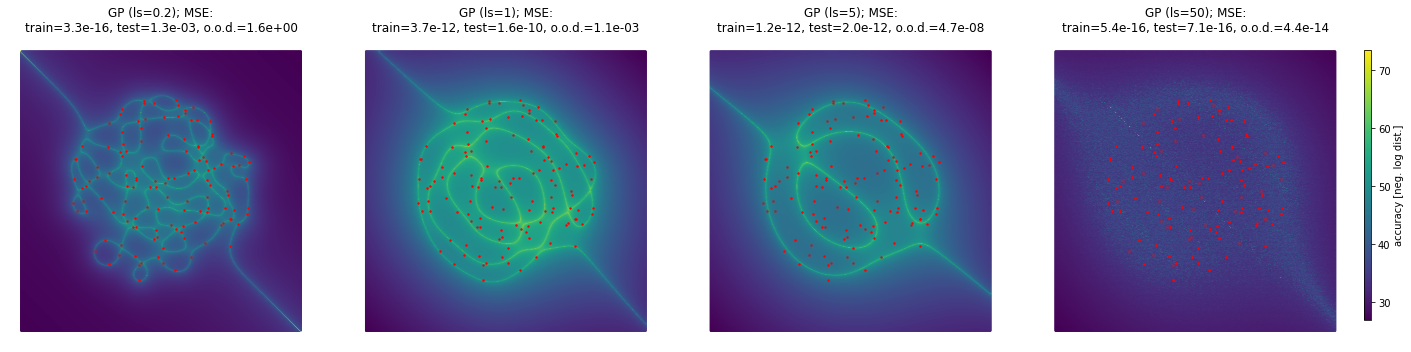

In [ ]:
# show results
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

plt.figure(figsize=(20, 5))
for i, length_scale in enumerate(length_scales):
  plt.subplot(1, 4, 1 + i)
  # compute neg log dist
  y_ = grid_predictions[i]
  nld = neg_log_dist(y_grid, y_)
  # plot
  im = plt.scatter(*x.T, c=nld, s=1)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("GP (ls=%s); MSE:\ntrain=%.1e, test=%.1e, o.o.d.=%.1e" % (
      length_scale, results['mse_trains'][i], results['mse_tests'][i], 
      results['mse_oods'][i]))
  plt.axis('off')
plt.tight_layout()

# one shared colobar
fig = plt.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.1, 0.005, 0.75])
fig.colorbar(im, cax=cbar_ax, label='accuracy [neg. log dist.]')

plt.show()

# Combined Figure

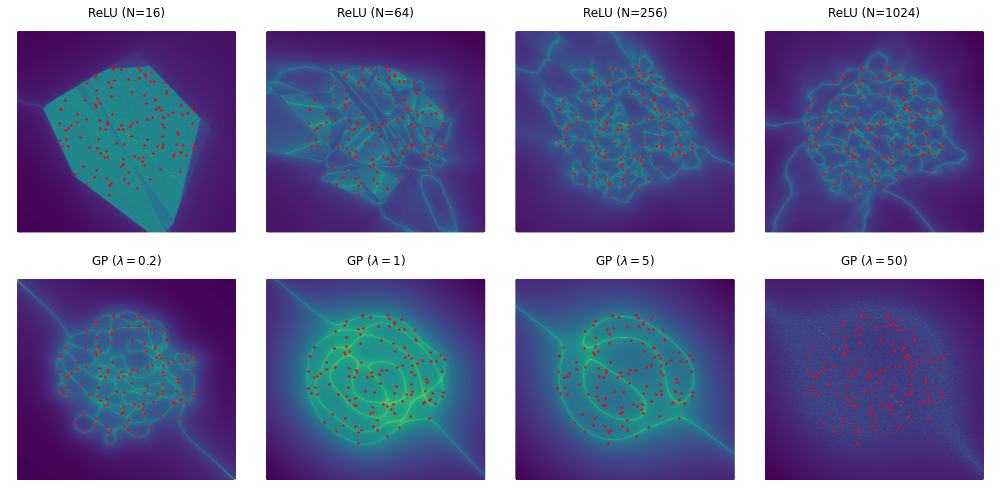

In [ ]:
fig = plt.figure(figsize=(14, 7))

### Top row: ReLU
with open(log_dir + 'add_disc_relu_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, num_hidden in enumerate(num_hiddens):
  plt.subplot(2, 4, 1 + i)
  y_ = results['grid_predictions'][i]
  nld = neg_log_dist(y_grid, y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title("ReLU (N=%s)" % num_hidden)
  plt.axis('off')

### Bottom row: GP
with open(log_dir + 'add_disc_gp_skl_results.pkl', 'rb') as handle:
    results = pickle.load(handle)
for i, length_scale in enumerate(length_scales[::1]):
  plt.subplot(2, 4, 1 + i + 4)
  y_ = results['grid_predictions'][::1][i]
  nld = neg_log_dist(y_grid, y_)
  im = plt.scatter(*x_grid.T, c=nld, s=1)
  #plt.colorbar(label='accuracy [neg. log dist.]')  # individual colorbars
  plt.scatter(*data.get_train()[0].T, color='red', s=2)
  plt.title(r"GP ($\lambda=%s$)" % length_scale)
  plt.axis('off')
plt.tight_layout()
plt.savefig(log_dir + 'fig1.png', dpi=500)
plt.show()